Датасет **Wine Quality** содержит данные о химическом составе красного и белого вина, а также их оценках качества. Этот датасет используется для прогнозирования качества вина на основе различных химических характеристик. В нем представлены следующие столбцы:

1. **fixed acidity**: фиксированная кислотность (например, яблочная кислота).
2. **volatile acidity**: летучая кислотность (например, уксусная кислота).
3. **citric acid**: лимонная кислота.
4. **residual sugar**: остаточный сахар.
5. **chlorides**: содержание хлоридов (например, соли).
6. **free sulfur dioxide**: свободный диоксид серы.
7. **total sulfur dioxide**: общий диоксид серы.
8. **density**: плотность.
9. **pH**: уровень pH.
10. **sulphates**: сульфаты.
11. **alcohol**: содержание алкоголя.
12. **quality**: оценка качества вина (целочисленная шкала от 0 до 10).

Датасет содержит 1143 экземпляра, каждый из которых представляет собой одно вино с набором химических характеристик и оценкой качества. Основная задача при работе с этим датасетом — это предсказание качества вина на основе химического состава.

In [2]:
!pip install opendatasets
!pip install bayesian-optimization
!pip install keras-tuner

In [3]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from tensorflow.keras import regularizers, layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [4]:
dataset_path = Path('wine-quality-dataset', 'WineQT.csv')

if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/yasserh/wine-quality-dataset')

df = pd.read_csv(dataset_path)
df.head()
df.shape

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xcution28
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/yasserh/wine-quality-dataset


100%|██████████| 21.5k/21.5k [00:00<00:00, 12.0MB/s]

(1143, 13)

In [5]:
# проверка на пропущенные значения
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


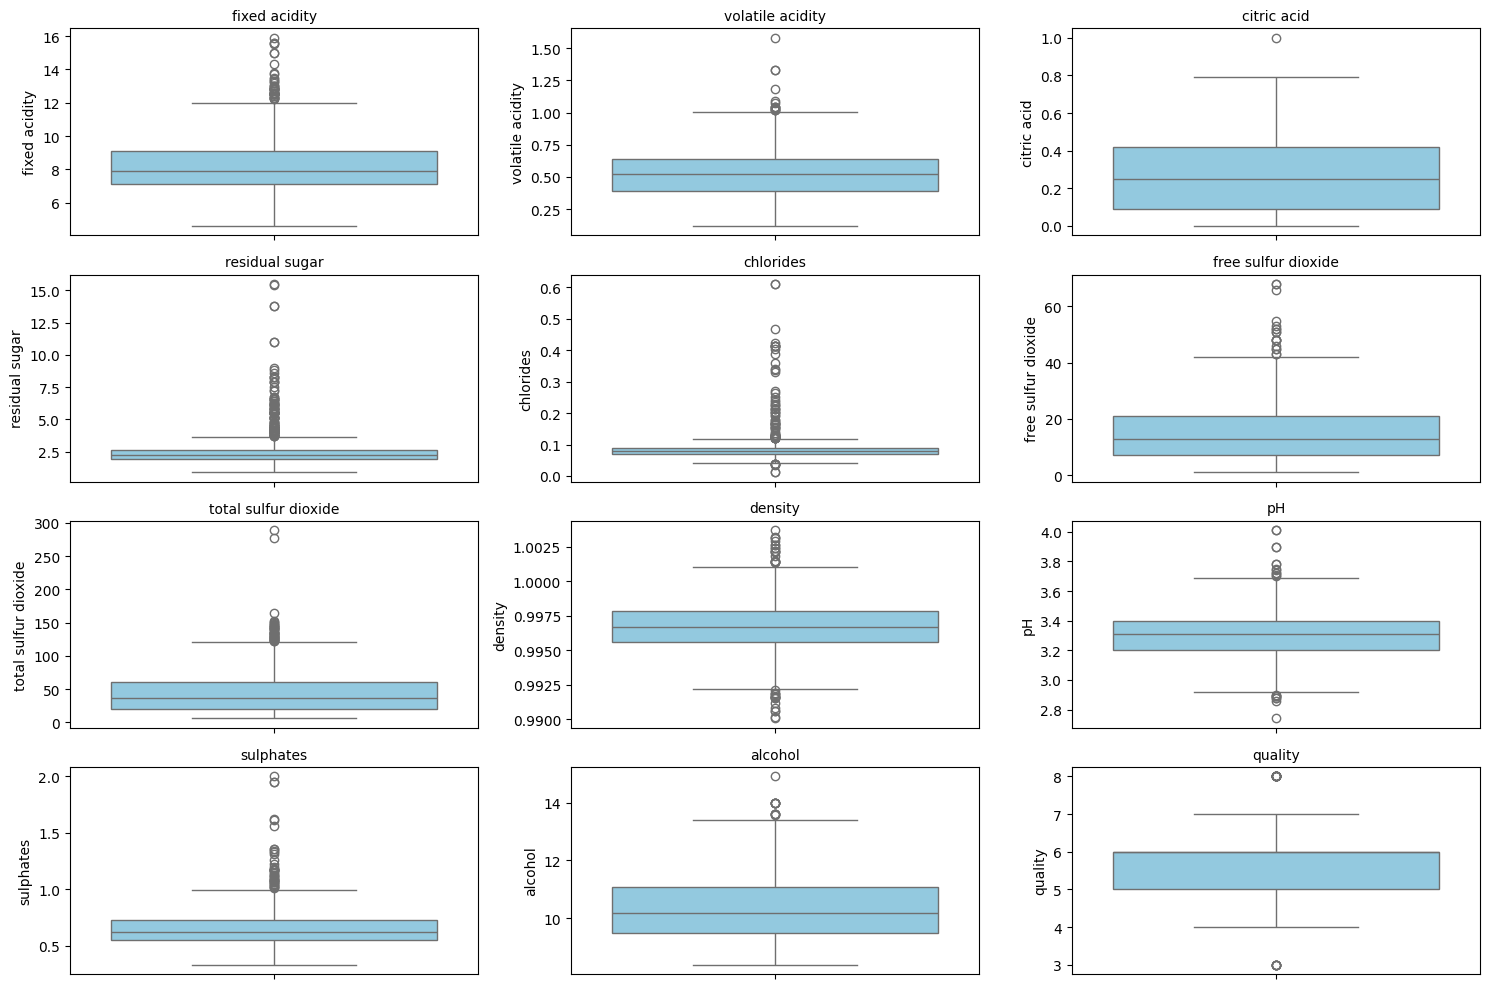

In [6]:
# Удалим столбец 'Id', так как он не влияет на выбросы
columns_to_check = df.drop(['Id'], axis=1).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()

In [7]:
# Удалим выбросы с помощью IQR
Q1 = df[columns_to_check].quantile(0.25)
Q3 = df[columns_to_check].quantile(0.75)
IQR = Q3 - Q1

# Определяем выбросы (значения, которые выходят за пределы 1.5*IQR)
outliers = ((df[columns_to_check] < (Q1 - 1.5 * IQR)) | (df[columns_to_check] > (Q3 + 1.5 * IQR)))

# Удаляем строки с выбросами
df_cleaned = df[~outliers.any(axis=1)]

# Смотрим что получилось
print(f"Количество строк до удаления выбросов: {df.shape[0]}")
print(f"Количество строк после удаления выбросов: {df_cleaned.shape[0]}")

Количество строк до удаления выбросов: 1143
Количество строк после удаления выбросов: 834


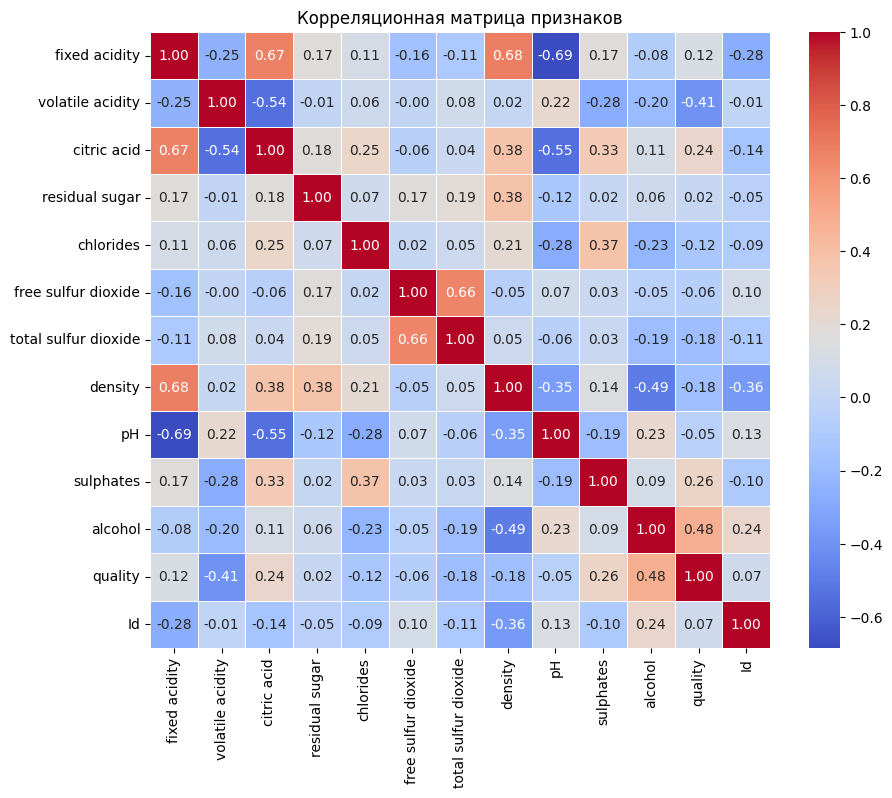

In [8]:
# Построение корреляционной матрицы
corr_matrix = df.corr()

# Визуализация с использованием heatmap
plt.figure(figsize=(10, 8))  # Размер изображения
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

plt.title('Корреляционная матрица признаков')
plt.show()

In [9]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df.drop(columns=['quality', 'Id'])  # Удаляем 'quality' и 'Id'
y = df['quality']

# Разбиваем на обучающую и тестовую выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация признаков
scaler = StandardScaler()

# Применяем стандартизацию к обучающим данным
X_train_scaled = scaler.fit_transform(X_train)

# Применяем стандартизацию к тестовым данным (используем fit из обучающей выборки)
X_test_scaled = scaler.transform(X_test)

# Проверим, как выглядят стандартизированные данные
print("Обучающие данные после стандартизации:")
print(X_train_scaled[:5])  # Печать первых 5 строк обучающих данных

print("\nТестовые данные после стандартизации:")
print(X_test_scaled[:5])  # Печать первых 5 строк тестовых данных

Обучающие данные после стандартизации:
[[ 0.1426802  -1.40273053  1.5096933  -0.55102394  0.11651554  1.88559834
   1.79122276  0.11355786 -0.09314751  0.56821234  0.05661327]
 [ 0.96843134 -1.17920341  1.5096933  -0.39776844 -0.28423884 -1.24188154
  -1.18572018 -0.7017669  -1.07474038  0.4477703   0.89445566]
 [ 0.3786091  -1.23508519  0.4833938   0.06199805 -0.64280855 -0.55774532
  -0.21429669 -0.55542656  0.56124774  0.20688622  1.26683005]
 [-0.97798208  1.95017634 -1.1586854  -0.24451294 -0.43188519 -0.36227782
  -0.80968528 -0.16866994  1.41196156 -0.57598704 -0.50194833]
 [-0.38815983 -0.6203856  -0.08107092  1.0581588   0.36962357  1.20146211
   1.38385162  0.6048433  -1.07474038 -0.51576602 -1.24669712]]

Тестовые данные после стандартизации:
[[-0.86001763  0.44136825 -1.1586854  -0.78090719 -0.62171622 -1.04641405
  -1.1230477  -0.74880486  0.69212679 -0.33510296 -0.87432272]
 [-0.8010354   1.72664922 -0.28633082  1.2114143  -0.26314651  0.02865716
   0.60044559  0.90797686

In [11]:
# Определяем функцию, которая строит модель с гиперпараметрами
def build_model(hp):
    model = Sequential()

    # Входной слой
    model.add(Input(shape=(X_train.shape[1],)))

    # Скрытые слои с регуляризацией и дропаутом
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                        activation='relu',
                        kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', [1e-2, 1e-3, 1e-4]))))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Выходной слой
    model.add(Dense(1, activation='linear'))

    # Компиляция модели
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae', 'mse'])

    return model

# Инициализация RandomSearch для поиска гиперпараметров
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # Максимальное количество попыток
    executions_per_trial=1,  # Количество запусков на каждой попытке
    directory='wine_quality_tuning',
    project_name='wine_quality_optimization')

# Отображение информации о поиске
tuner.search_space_summary()

# Поиск оптимальных гиперпараметров
tuner.search(X_train_scaled, y_train,
             epochs=20,
             validation_data=(X_test_scaled, y_test),
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Получаем лучшую модель
best_model = tuner.get_best_models(num_models=1)[0]

# Оценка лучшей модели на тестовой выборке
loss, mae, mse = best_model.evaluate(X_test_scaled, y_test)
print(f'Test Loss (MSE): {loss}')
print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')

# Предсказания на тестовых данных
y_pred = best_model.predict(X_test_scaled)

# Пример: Можем вывести первые 5 предсказаний и реальные значения
print(f'Predictions: {y_pred[:5].flatten()}')
print(f'Actual values: {y_test[:5].values}')

Trial 20 Complete [00h 00m 16s]
val_loss: 0.47774890065193176

Best val_loss So Far: 0.3672693173090617
Total elapsed time: 00h 08m 27s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3491 - mae: 0.4727 - mse: 0.3472
Test Loss (MSE): 0.35717836022377014
Test MAE: 0.47093990445137024
Test MSE: 0.35521742701530457
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predictions: [5.257741  4.934564  5.1388884 5.5284014 6.109874 ]
Actual values: [5 6 5 6 6]


In [12]:
# Предсказания на тестовых данных
y_pred = best_model.predict(X_test_scaled)

# Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Средняя квадратичная ошибка (MSE)
mse = mean_squared_error(y_test, y_pred)

# Корень из средней квадратичной ошибки (RMSE)
rmse = np.sqrt(mse)

# Коэффициент детерминации (R²)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Absolute Error (MAE): 0.47093992982889366
Mean Squared Error (MSE): 0.3552174199406938
Root Mean Squared Error (RMSE): 0.5960011912242238
R² Score: 0.36166274547576904


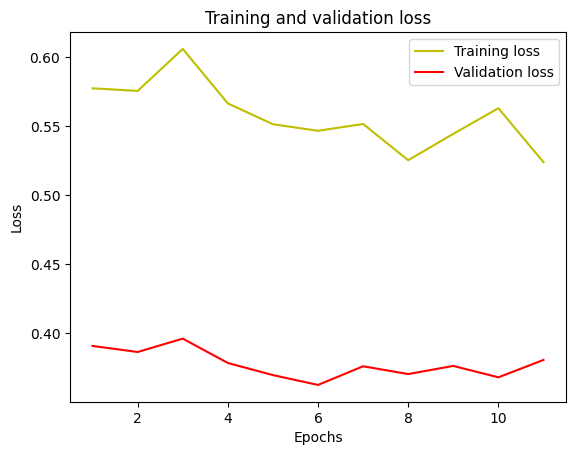

In [13]:
# Обучение лучшей модели на всех данных для построения графика
history = best_model.fit(X_train_scaled, y_train,
                         epochs=50,
                         validation_data=(X_test_scaled, y_test),
                         callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                         verbose=0)

# Получаем значения потерь для обучения и валидации
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Строим график
plt.plot(epochs, loss, 'y', label='Training loss')  # Потери на обучающей выборке (горчичный)
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # Потери на валидационной выборке (красный)

# Добавляем заголовок и подписи
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()